# Weather Forescast

## Introduction


A stationary time series is one whose properties do not depend on the time at which the series is observed.15 Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.


A stationary time series is one whose properties do not depend on the time at which the series is observed. In general, a stationary time series will not exhibit predictable patterns in the long term. Therefore, a time series with a trend or seasonality is non-stationary. On the other hand, a white noise series is stationary because, regardless of when you observe it, it should look practically the same at any point in time.


These are the following properties that any stationary model will have:

- Constant mean
- Constant variance (there may be variations, but the variations should not be irregular)
- Constant covariance
- No seasonality (no repetitive patterns in the dataset)

Some cases can be confusing: a time series with cyclical behavior (but without trend or seasonality) is stationary. This is because cycles do not have a fixed duration, so before observing the series, we cannot be sure where the peaks and valleys of the cycles will be. In the long term, the timing of these cycles is not predictable. Therefore, the series is stationary.

**Trend**
There is a trend when there is a long-term increase or decrease in the data.

**Seasonal**
A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of year or the day of the week. Seasonality always has a fixed and known frequency.

**Cyclical**
A cycle occurs when the data exhibit ups and downs that do not have a fixed frequency. These fluctuations are often due to economic conditions and are often related to the "economic cycle." The duration of these fluctuations is usually at least 2 years.

<a name="top"></a>
 
## Table of Contents 
* [1. Data collection Data preprocessing](#item1)
* [2. Data preprocessing](#item2)
    * [2.1. Setting Date Column as Time Series Index](#item2.1)
    * [2.2. Chronological Arrangement of Time](#item2.2)
    * [2.3. Frequency of the time series](#item2.3)
    * [2.4. Stationary time series](#item2.4)
        * [2.4.1. Augmented Dickey–Fuller test](#item2.4.1)
        * [2.4.2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS Test)](#item2.4.2)
        * [2.4.3. Graph the Data Series](#item2.4.3)
        * [2.4.4. Time series decomposition](#item2.4.4)
        * [2.4.5. Autocorrelation in Time Series Data](#item2.4.5)
        * [2.4.6. Partial Autocorrelation in Time Series Data](#item2.4.6)
* [3. Prediction models](#item3)
    * [3.1. ARIMA](#item3.1)
        * [3.1.1. Train-Test Data Split](#item3.1.1)
        * [3.1.2.  Select Model Parameters with Auto_ARIMA.](#item3.1.2)
        * [3.1.3. ARIMA Model Creation](#item3.1.3)
        * [3.1.4. Analysis of the prediction residual](#item3.1.4)
            * [3.1.4.1. Histogram and Density](#item3.1.4.1)
            * [3.1.4.2. Residuals graph ](#item3.1.4.2)
            * [3.1.4.3. Autocorrelation Function ](#item3.1.4.3)
            * [3.1.4.4. Analyzing the decomposition of residuals](#item3.1.4.4)
        * [3.1.5. Prediction](#item3.1.5)
        * [3.1.6. Model Metric](#item3.1.6)
    * [3.2 Sarima](#item3.2)
        * [3.2.1. Frequency of the time series](#item3.2.1)
        * [3.2.2. Chronological Arrangement of Time](#item3.2.2)
        * [3.2.3. Train-Test Data Split](#item3.2.3)
        * [3.2.4. Select Model Parameters with Auto_ARIMA](#item3.2.4)
        * [3.2.5. SARIMA Model Creation](#item3.2.5)
        * [3.2.6. Analysis of the prediction residual](#item3.2.6)
            * [3.2.6.1. Histogram and Density](#item3.2.6.1)
            * [3.2.6.2. Residuals graph](#item3.2.6.2)
            * [3.2.6.3. Autocorrelation Function](#item3.2.6.3)
            * [3.2.6.4. Analyzing the decomposition of residuals](#item3.2.6.4)
        * [3.2.7. Prediction](#item3.2.7)
        * [3.2.8. Model Metrics](#item3.2.8)

<a name="item1"></a>
## 1. Data collection and preprocessing

In [9]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
from time import sleep
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pmdarima as pm
import statsmodels.api as sm
import matplotlib.dates as mdates

Data collected in the "Climate Change in Spain with Animation" project is downloaded.

In [10]:
data_weather = pd.read_csv("Weather.csv", index_col=0, header=0)
data_weather['Time'] = pd.to_datetime(data_weather['Time'])

In [11]:
data_weather.head()

,Time,Mean Temperature,Maximum Temperature,Minumum Temperature,Total Precipitation,Total Snowfall,Maximum Wind Speed,Capital City,Autonomous Community,Latitude,Longitude
0,1963-01-01,4.3,5.9,3.1,27.3,0.0,19.1,La Coruña,Galicia,43.13,-8.46
1,1963-01-02,5.5,6.6,2.9,26.2,0.0,23.1,La Coruña,Galicia,43.13,-8.46
2,1963-01-03,3.5,6.9,0.6,3.3,0.0,17.6,La Coruña,Galicia,43.13,-8.46
3,1963-01-04,6.6,10.6,3.7,8.1,0.0,26.8,La Coruña,Galicia,43.13,-8.46
4,1963-01-05,9.4,10.5,8.5,5.2,0.0,28.2,La Coruña,Galicia,43.13,-8.46


Climate data from the capitals are extrapolated to the communities and the country in general.

In [14]:
def data_daily_average (df_raw):
    
    # freq is the wished frequency in the data set. 
    
    # climate variables to analyze
    variable = ['Mean Temperature','Minumum Temperature','Maximum Temperature','Total Precipitation','Maximum Wind Speed']
    
    df_raw = df_raw.rename(columns= {'Minumum Temperature':'Minimum Temperature'})
    
    #1. Calculate the daily average for each climate variable
    for place in ["Autonomous Community", "Capital City", "Spain"]:
            
        if place != "Spain":
            
            # Data were grouped by specific geographic area (autonomous community or capital) and date.
            # The mean temperature and maximum velocity are averaged for the day, and the total daily precipitation is summed.
            df = df_raw.groupby([place,"Time"]).agg({'Mean Temperature'    :'mean',
                                                     'Minimum Temperature'    :'mean',
                                                 'Maximum Temperature'    :'mean',
                                                 'Maximum Wind Speed'  :'mean', 
                                                 'Total Precipitation' : 'sum'}).reset_index()
        
        else:
            
            df = df_raw.groupby("Time").agg({'Mean Temperature'    :'mean',
                                             'Minimum Temperature'    :'mean',
                                             'Maximum Temperature'    :'mean',
                                             'Maximum Wind Speed'  :'mean', 
                                             'Total Precipitation' : 'sum'}).reset_index()

        df = df.round(2)
        
        # Create a folder to save the charts if it does not exist
        output_folder = f"Data_weather_daily/{place}"
            
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
            
        if place == "Capital City":
            
            data_capital = df.copy()
             # Save the plot in the folder
            output_filename = os.path.join(output_folder, f"Capital.csv")
        
        elif place == "Autonomous Community":
            
            data_community = df.copy()
            output_filename = os.path.join(output_folder, f"Community.csv")
            
        elif place == "Spain":
            
            data_spain = df.copy()
            output_filename = os.path.join(output_folder, f"Spain.csv")

        df.to_csv(output_filename, decimal=',')
        
    return data_capital, data_spain, data_community

In [15]:
data_capital, data_spain, data_community = data_daily_average (data_weather)

Spain's data was used to predict.

In [16]:
data_spain.head()

,Time,Mean Temperature,Minimum Temperature,Maximum Temperature,Maximum Wind Speed,Total Precipitation
0,1963-01-01,6.57,3.82,9.76,18.47,596.3
1,1963-01-02,8.03,4.77,11.17,27.53,677.9
2,1963-01-03,5.01,3.01,7.51,22.04,140.6
3,1963-01-04,5.57,2.63,8.83,16.25,289.0
4,1963-01-05,8.68,6.37,11.96,18.42,287.5


In [7]:
data_spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21915 entries, 0 to 21914
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Time                 21915 non-null  datetime64[ns]
 1   Mean Temperature     21915 non-null  float64       
 2   Minimum Temperature  21915 non-null  float64       
 3   Maximum Temperature  21915 non-null  float64       
 4   Maximum Wind Speed   21915 non-null  float64       
 5   Total Precipitation  21915 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.0 MB


<a name="item2"></a>
## 2. Data preprocessing

The necessary data preprocessing steps required before applying prediction algorithms are detailed below.

<a name="item2.1"></a>
### 2.1. Setting Date Column as Time Series Index

First, it is necessary to set the date as a time series index.

In [17]:
data_spain = data_spain.set_index("Time")

In [18]:
data_spain.head()

,Mean Temperature,Minimum Temperature,Maximum Temperature,Maximum Wind Speed,Total Precipitation
Time,,,,,
1963-01-01,6.57,3.82,9.76,18.47,596.3
1963-01-02,8.03,4.77,11.17,27.53,677.9
1963-01-03,5.01,3.01,7.51,22.04,140.6
1963-01-04,5.57,2.63,8.83,16.25,289.0
1963-01-05,8.68,6.37,11.96,18.42,287.5


<a name="item2.2"></a>
### 2.2. Chronological Arrangement of Time

Time data should be organized chronologically.

In [19]:
data_spain = data_spain.sort_values(by ='Time')

<a name="item2.3"></a>
### 2.3. Frequency of the time series

It's important to ensure that your time series data has a set frequency. 

In [20]:
#Ask the frequency 
print(data_spain.index.freq)

None


If the time series doesn't have a set frequency, it is necessary to establish one.

In [21]:
data_spain = data_spain.sort_index()
data_spain.index.freq = "D"

In [22]:
print(data_spain.index.freq)

<Day>


<a name="item2.4"></a>
### 2.4. Stationary time series

The goal of this project was to predict the average temperature in Spain. Then, the Stationary of the following data set was analyzed:

In [14]:
data_spain[['Mean Temperature']].head()

,Mean Temperature
Time,
1963-01-01,6.57
1963-01-02,8.03
1963-01-03,5.01
1963-01-04,5.57
1963-01-05,8.68


<a name="item2.4.1"></a>
#### 2.4.1. Augmented Dickey–Fuller test (ADF Test)

In [23]:
from statsmodels.tsa.stattools import adfuller

def ad_test(x):
    
     print ('Results of ADF Test:')
        
     dftest = adfuller(x, autolag = 'AIC')
    
     print("1. ADF Statistic : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
        
     for key, val in dftest[4].items():
        
         print("\t",key, ": ", val)
     
     print()
        
     print("Conclusion of ADF Test:")
    
     if dftest[1] <= 0.05:
            
        print("           The time series has a metric p < 0.05. The time series is difference-stationary.")
        
        adfuller_result = True
        
     else:
        
        print("           The time series has a metric p > 0.05. The time series is not stationary.")
        
        adfuller_result = False
        
     return adfuller_result
        
# p is a metric

<a name="item2.4.2"></a>
#### 2.4.2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS Test)

In [24]:
def kpss_test(timeseries):
    
    from statsmodels.tsa.stattools import kpss
    
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    print()
    
    print("Conclusion of KPSS Test:")

    if (kpss_output['p-value'] > 0.05) and (kpss_output['Test Statistic'] < kpss_output['Critical Value (10%)']) and (kpss_output['Test Statistic'] < kpss_output['Critical Value (5%)']) and (kpss_output['Test Statistic'] < kpss_output['Critical Value (2.5%)']) and (kpss_output['Test Statistic'] < kpss_output['Critical Value (1%)']):
        
        print("               The time series is trend-stationary.")
   
        kpss_result = True
    
    else:
        
        print("               The time series is not stationary.")
        
        kpss_result = False
    
    return kpss_result 

In [25]:
def stationary (df):
    
    adfuller_result = ad_test(df) #se envia un arreglo
    
    print()
    print("**************************")
    print()
    
    kpss_result = kpss_test(df)
    
    print()
    print("**************************")
    print()
    
    print("Conclusion of ADF and KPSS Tests:")
    
    if adfuller_result == True and kpss_result == True:
    
        print("                     The time series is strictly stationary.")

    elif adfuller_result == False and kpss_result == True:

        print("                     The time series is trend-stationary. Eliminate the trend to make the time series strictly stationary")

    elif adfuller_result == True and kpss_result == False:      

        print("                     The time series is difference-stationary.Use differentiation to make the time series strictly stationary.")
        
    elif adfuller_result == False and kpss_result == False:  
        
        print("                     The time series is not difference-stationary.Use differentiation to make the time series strictly stationary.")

In [18]:
stationary(data_spain[['Mean Temperature']])

Results of ADF Test:
1. ADF Statistic :  -13.479096430065843
2. P-Value :  3.267875289238229e-25
3. Num Of Lags :  47
4. Num Of Observations Used For ADF Regression: 21867
5. Critical Values :
	 1% :  -3.430649083907571
	 5% :  -2.861672185197276
	 10% :  -2.566840358460621

Conclusion of ADF Test:
           The time series has a metric p < 0.05. The time series is difference-stationary.

**************************

Results of KPSS Test:
Test Statistic            0.32108
p-value                   0.10000
#Lags Used               88.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64

Conclusion of KPSS Test:
               The time series is trend-stationary.

**************************

Conclusion of ADF and KPSS Tests:
                     The time series is strictly stationary.


/Users/Cinti/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<a name="item2.4.3"></a>
#### 2.4.3. Graph the Data Series

In [90]:
def Graphic_Serie (df,name = "Times series"):
    
    #crear una figura
    fig = plt.figure(figsize=(12,6))
    #agregar ejes a la figura (objeto de ejes)
    ax = fig.add_subplot(111)
    
    # Crear un gráfico de la serie de tiempo en el objeto de ejes
    ax.plot(df, label=name, color = 'blue')
    ax.set_title(name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean temperature')
    ax.legend()
    ax.grid(True)
    
    return fig
    

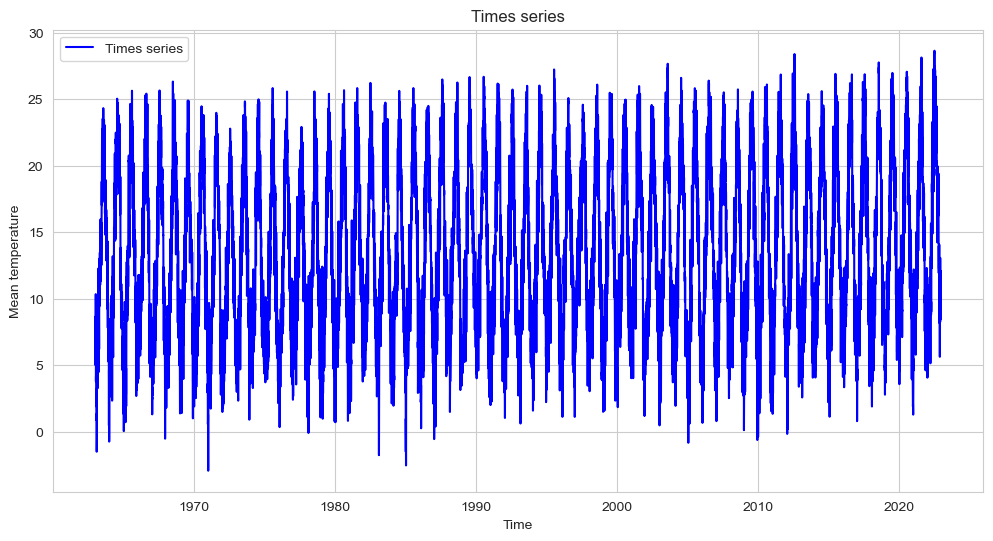

In [91]:
fig = Graphic_Serie(data_spain['Mean Temperature'])
plt.show()

It may be required to limit the time period for studying stationary.

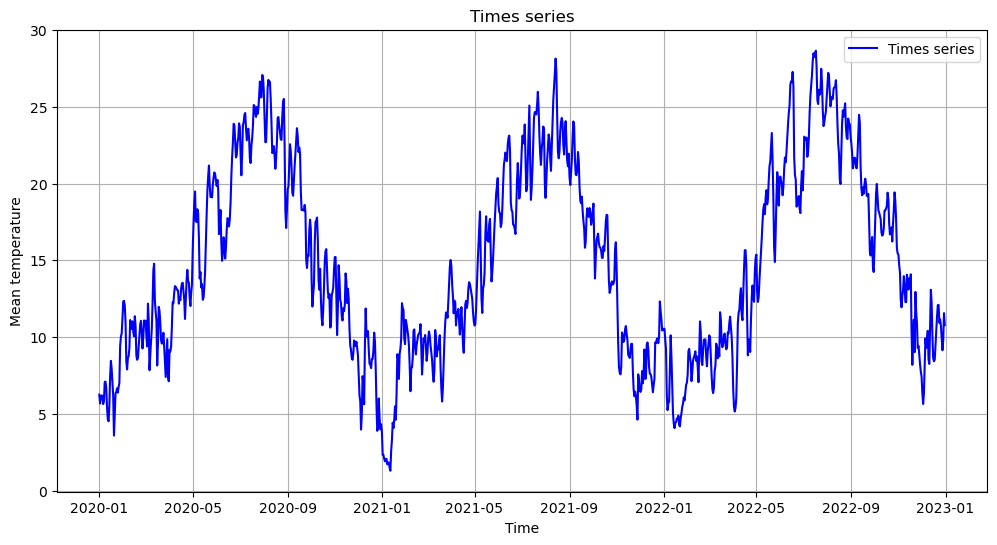

In [36]:
fig = Graphic_Serie(data_spain[data_spain.index.year.isin([2020, 2021, 2022])]['Mean Temperature'])
plt.show()

---------
### Partial conclusion

- By reducing the time interval of the time series, it is possible to observe that the series is non-stationary.

- The data graph illustrates a pattern where the temperature rises during summer and falls in the following months, repeating annually.

---------


<a name="item2.4.4"></a>
#### 2.4.4. Time series decomposition

In [27]:
def descomposition_serie (df):
    
    import statsmodels.api as sm

    # Realiza la descomposición de la serie de tiempo
    decomposition = sm.tsa.seasonal_decompose(df, model='additive')

    # Extrae los componentes
    Trend = decomposition.trend
    Seasonal = decomposition.seasonal
    Resid = decomposition.resid

    # Graficar los componentes
    fig = plt.figure(figsize=(12, 8))

    plt.subplot(311) # subplot(num filas, num columnas, posición del subgráfico en esa cuadrícula
    plt.plot(Trend, label='Trend')
    plt.title('Trend component')
    plt.legend()

    plt.subplot(312)
    plt.plot(Seasonal, label='Seasonal')
    plt.title('Seasonal component')
    plt.legend()

    plt.subplot(313)
    plt.plot(Resid, label='Resid')
    plt.title('Resid component')
    plt.legend()

    plt.tight_layout()

    return fig

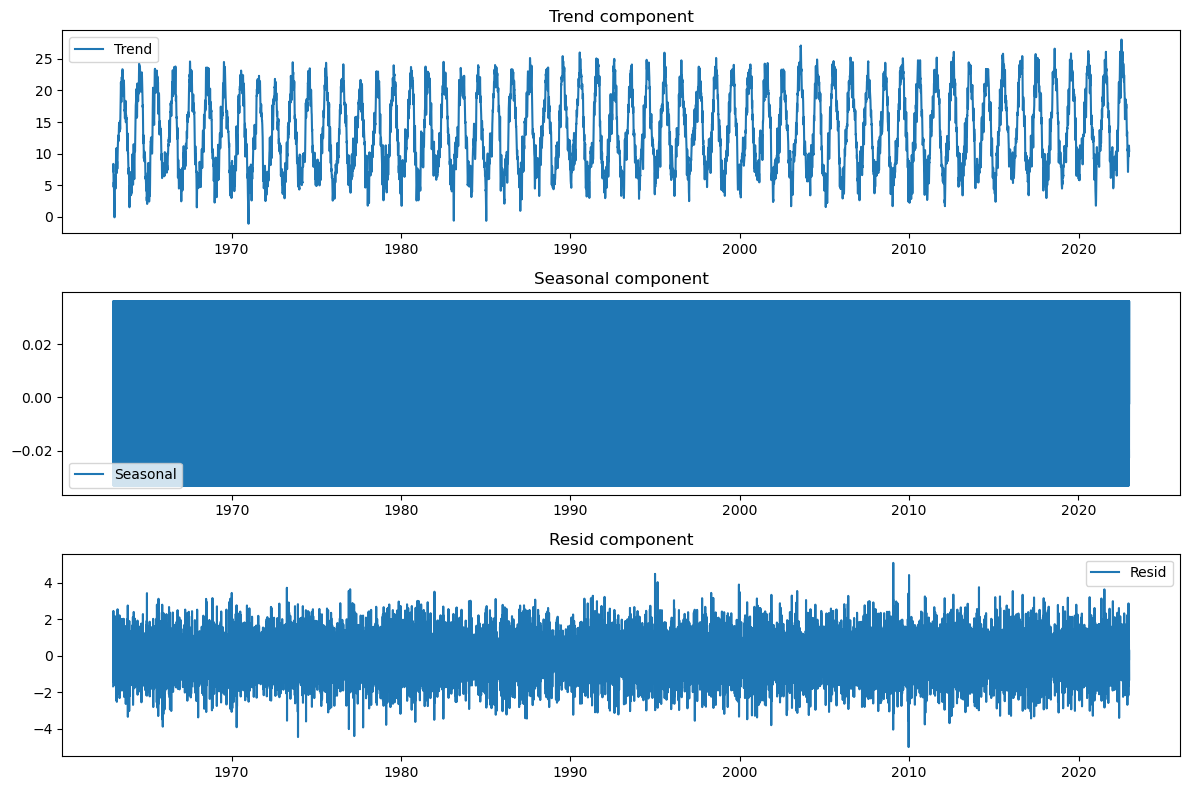

In [37]:
fig_desc = descomposition_serie(data_spain['Mean Temperature'])

plt.show()

The time range has been reduced in order to better observe the stationary behavior of the data.

The graph presented below illustrates the trend, seasonal, and residual components of data from the years 2020 to 2022.

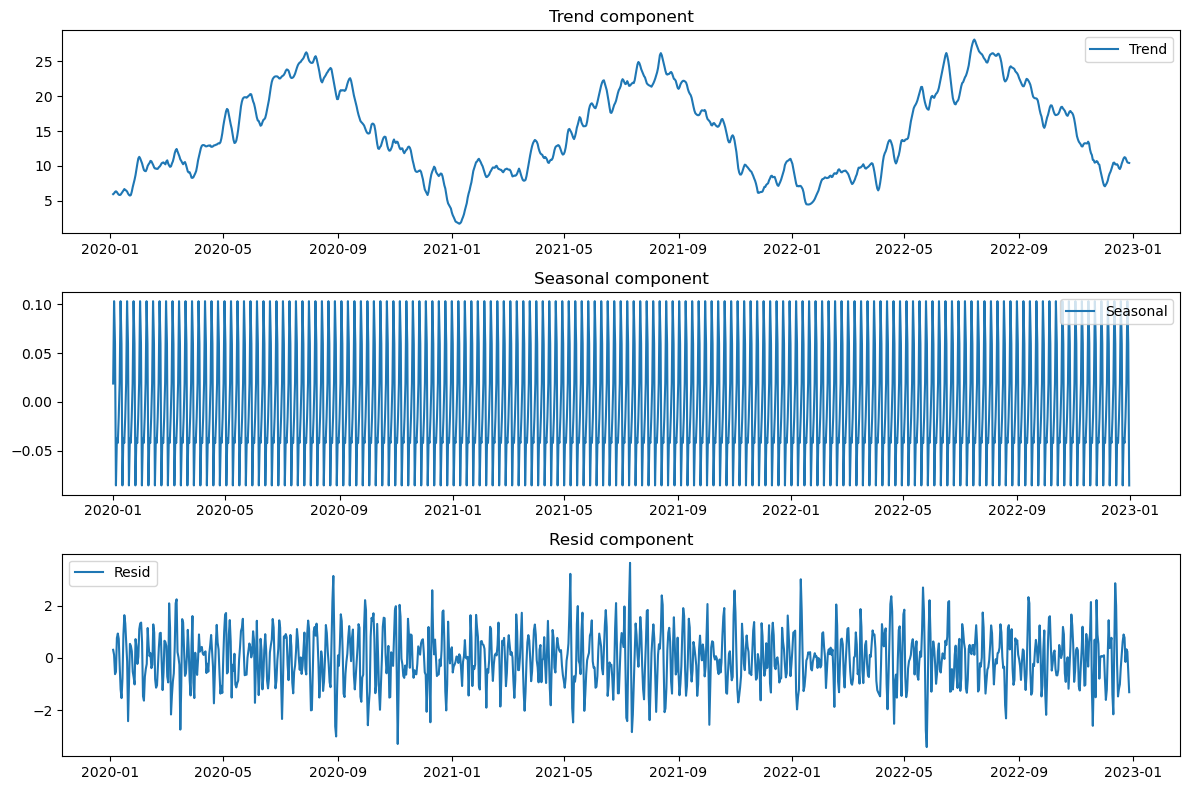

In [94]:
fig_desc = descomposition_serie(data_spain[data_spain.index.year.isin([2020, 2021, 2022])]['Mean Temperature'])
plt.show()

The below graphs only represent data for the year 2020.

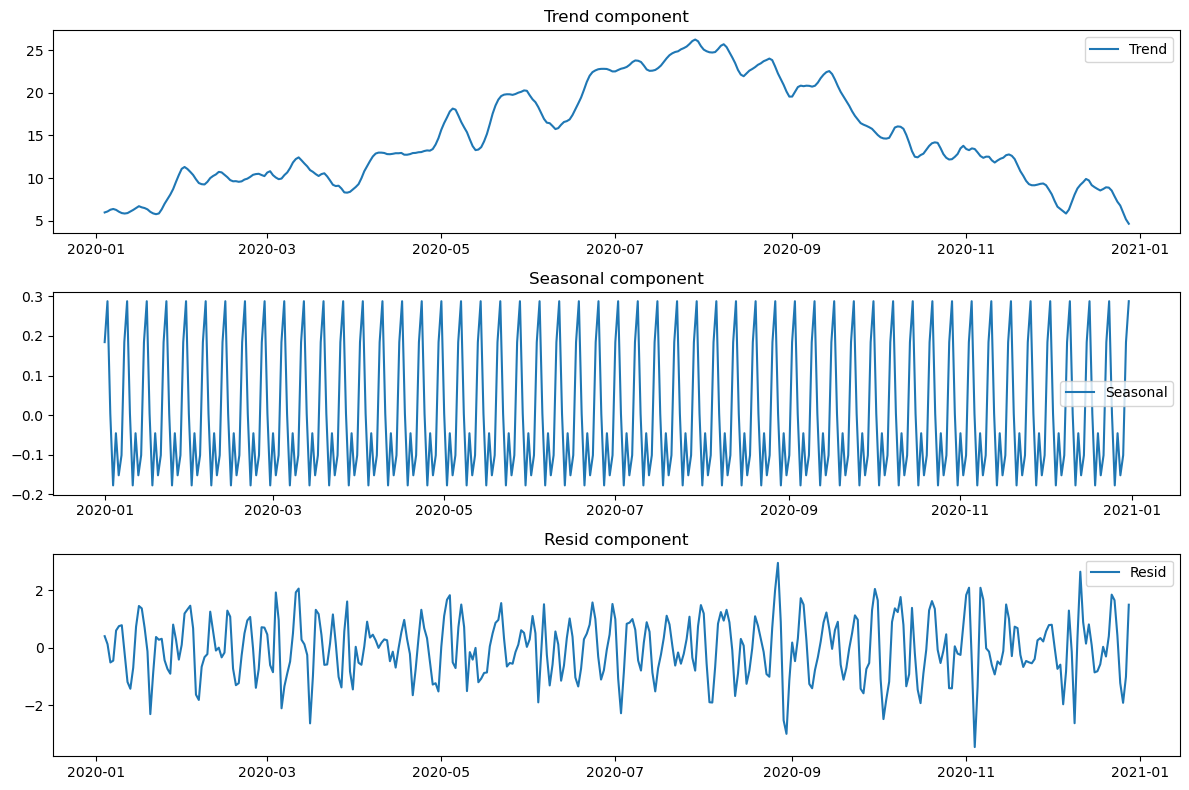

In [95]:
fig_desc = descomposition_serie(data_spain[data_spain.index.year.isin([2020])]['Mean Temperature'])
plt.show()

--------

### Partial conclusion
Upon examining the decomposition graphs, it becomes clear that:

- The trend component shows that the dataset has a temperature trend, with temperatures rising during the summer months and falling afterwards.
- The seasonal component displays repetitive patterns, indicating the presence of seasonality in the data. Without a seasonal component, the data would form a straight line with a value of zero or small variations around it.

The obtained results are consistent with the ones obtained through graphing the data series.

--------


<a name="item2.4.5"></a>
#### 2.4.5. Autocorrelation in Time Series Data

In [28]:
# Autocorrelation

def Autocorrelation (df):

    from statsmodels.graphics import tsaplots


    # Stands for Time Series Analysis Plots (TSA Plots)
    fig = plt.figure(figsize = (12,6))
    
    tsaplots.plot_acf(df, ax=fig.gca(), lags=60)

    plt.xlabel("Lag at k")
    plt.ylabel("Correlation coefficient")
    #plt.show()
    
    return fig

    #banda de confianza = zona celeste

    #El valor 0 siempre es 1 porque tiene una correlación perfecta con el paso de tiempo actual.

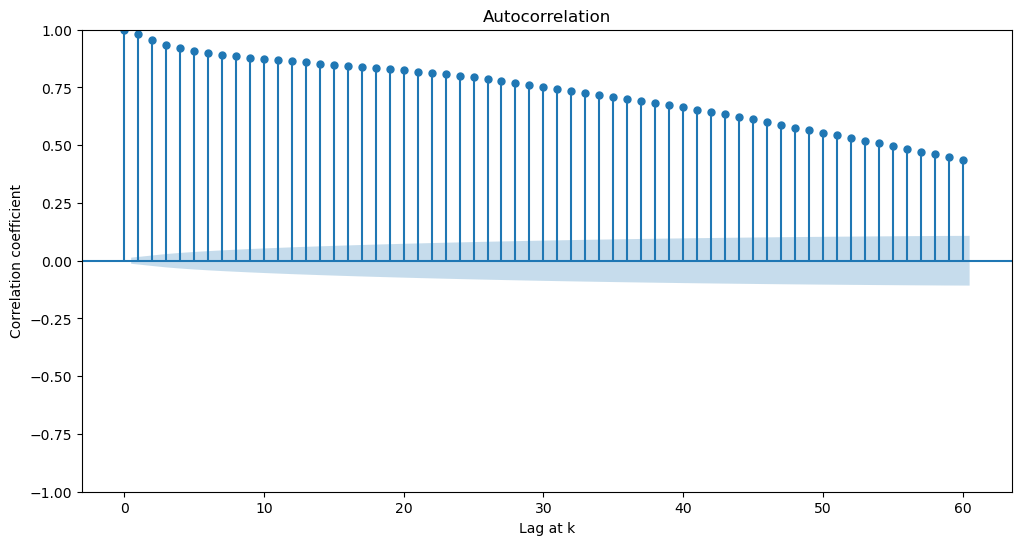

In [87]:
fig_ACF = Autocorrelation(data_spain['Mean Temperature'])
plt.show()

The blue shaded area on an autocorrelation plot typically represents confidence bounds, and values falling within this area are not considered statistically significant.


--------

### Partial conclusion

Significant values are observed (outside the blue area) that slowly decay. This demonstrates that time series is not stationarity because it has a trend.

For a stationary time series, the ACF will drop to zero relatively quickly.

----

<a name="item2.4.6"></a>
#### 2.4.6. Partial Autocorrelation in Time Series Data

In [29]:
# partial autocorrelation

def Partial_Autocorrelation (df):

    from statsmodels.graphics import tsaplots

    fig = plt.figure(figsize = (12,6))
    
    tsaplots.plot_pacf(df, ax=fig.gca()) 

    plt.title("Partial Autocorrelation")
    plt.xlabel("Lag at k")
    plt.ylabel("Correlation Coefficient")
    #plt.show()
    
    return fig

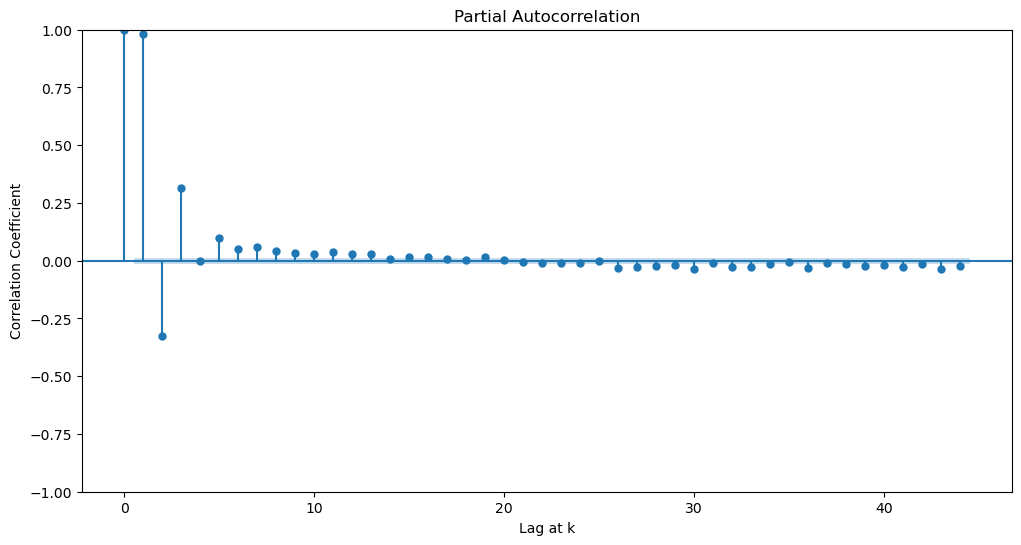

In [51]:
fig_PACF = Partial_Autocorrelation(data_spain['Mean Temperature'])

--------

### Partial conclusion
Most of the values are significant and outside the blue area, demonstrating a strong correlation between the data.

------

### Conclusion:

It is evident that the series has a trend and seasonality, indicating that it is not stationary. Therefore, the series must be differentiated to make it stationary.

-----

<a name="item3"></a>
## 3. Prediction models

The autoregressive integrated moving average model (ARIMA), the seasonal autoregressive integrated moving average model (SARIMA), Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX), and PROPHET are also commonly used models in time series analysis. These models are used in this project to predict average Mean Temperature of Spain.

<a name="item3.1"></a>
### 3.1. ARIMA

ARIMA, short for autoregressive integrated moving average, is a statistical model that utilizes time-series data to analyze and predict future trends. The model is considered autoregressive since it predicts future values based on past data.

Arima term can be divided into three terms, AR(p), I(d), MA(q).

It is a model that does not consider seasonality, it only takes into account the trend. The parameter 'd' is the one that analyzes how many differentiations must be made for the series to be stationary.

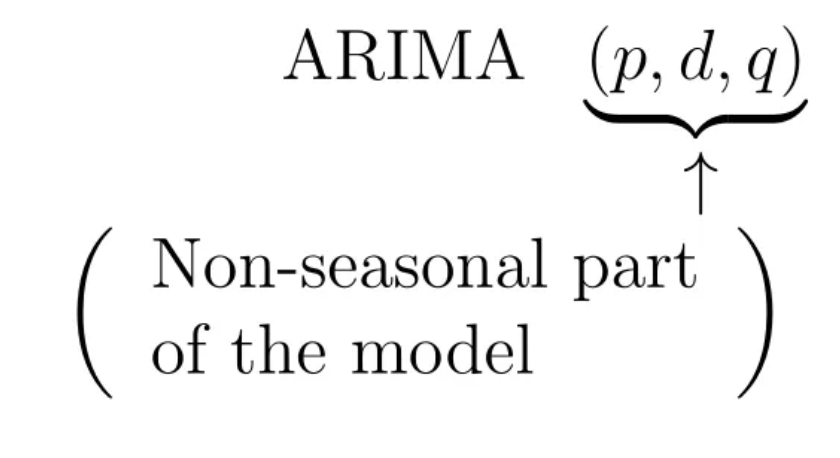

- **AR(p):** 

AR stands for the autoregressive model. It is a statistical model that predicts future values based on past values.  In this way, the p parameter is an integer that confirms how many lagged series are going to be used to forecast periods ahead.
    
The order, p, of the autoregressive model can be determined by looking at the partial autocorrelation function (PACF). The PACF gives the partial correlation of a time series with its own lagged values


- **MA(q):** 

MA stands for the moving average model. It is similar to an Autoregressive model, except that instead of being a linear combination of past time series values, it is a linear combination of the past white noise terms. This means that the MA model sees such random white noise "shocks" directly at each current value of the model.  
    
The order of the MA component, denoted by q, represents the number of lagged forecast errors used in the model.The order of the moving average model, q, can usually be estimated by looking at the ACF plot of the time series.

- **I(d):** 

I is the differencing part, the d parameter tells how many differencing orders are going to be used to make the series stationary. 
    
The way to convert a non-stationary series into a stationary series is through ordinary differentiation and/or through seasonal differences.
    
Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.
    
The differentiation is the way to convert a non-stationary series into a stationary series. It could be an ordinary differentiation and/or a seasonal difference.
    
- Seasonal differencing is defined as a difference between a value and a value with lag that is a multiple of S. With S = 12 (S is seasonal of the data set), which may occur with monthly data, a seasonal difference is.
        
- Ordinary differencing is need when there is a trend in the data.

#### Ordinary differencing 

When a differentiation is made, NAN data is generated which must be eliminated to continue the analysis.

In [56]:
df_difference = data_spain[['Mean Temperature']]
df_difference.diff().dropna()

,Mean Temperature
Time,
1963-01-02,1.46
1963-01-03,-3.02
1963-01-04,0.56
1963-01-05,3.11
1963-01-06,-0.02
...,...
2022-12-27,-0.84
2022-12-28,-0.76
2022-12-29,0.63


##### Seasonal differencing 

Data set has daily data with an annual seasonality. So the differentiation station is:

In [55]:
seasonal_periodicity = 365  # or 366 depending on the year

df_difference = data_spain[['Mean Temperature']]
df_difference['seasonal_difference'] = df_difference['Mean Temperature'].diff(periods=seasonal_periodicity)

In [50]:
df_difference.head(5)

,Mean Temperature,seasonal_difference
Time,,
1963-01-01,6.57,NaN
1963-01-02,8.03,NaN
1963-01-03,5.01,NaN
1963-01-04,5.57,NaN
1963-01-05,8.68,NaN


In [51]:
df_difference.tail(5)

,Mean Temperature,seasonal_difference
Time,,
2022-12-27,9.90,-2.42
2022-12-28,9.14,-2.55
2022-12-29,9.77,-1.40
2022-12-30,11.56,1.13
2022-12-31,10.78,0.29


With this differentiation, the first 365 days are NAN, which must be eliminated to continue the analysis.

In [52]:
# Elimina los primeros 12 meses que ahora contienen valores NaN
df_difference = df_difference[365:]

In [53]:
df_difference.head()

,Mean Temperature,seasonal_difference
Time,,
1964-01-01,4.53,-2.04
1964-01-02,4.25,-3.78
1964-01-03,5.22,0.21
1964-01-04,5.11,-0.46
1964-01-05,4.47,-4.21


<a name="item3.1.1"></a>
#### 3.1.1. Train-Test Data Split

To evaluate your model's performance, you should split your time series data into separate training and test sets. The training set is used to train the model, while the test set is reserved to evaluate its accuracy in predicting new data. 

In time series analysis, data is usually split sequentially, designating the initial portion as the training set and the remaining as the test set.

Remember that the size of your training and test sets can significantly affect your model's performance. A training set that is too small can lead to an underfitting model, while a huge one can lead to overfitting. Striking the right balance between the sizes of these subsets is crucial. 

In [32]:
def Train_Test_data(df, test_percentage):
    """
    Split time series data into training and testing sets.

    Parameters:
    - df (pd.DataFrame): Time series data.
    - test_percentage (float): Percentage of data to be used for testing.

    Returns:
    - X_train (pd.DataFrame): Training data.
    - X_test (pd.DataFrame): Testing data.
    """
    # Calculate the number of data points for testing
    num_test = int(len(df) * test_percentage)

    # Divide the time series into training and testing data
    X_train = df[:len(df) - num_test]
    X_test = df[len(df) - num_test:]

    # Display information about the training and testing data
    print(f"Training data: {len(X_train)}")
    print(X_train.tail(5))
    print("\n\n")
    print(f"Test data: {len(X_test)}")
    print(X_test.head(5))

    return X_train, X_test


In [42]:
X_train, X_test = Train_Test_data(data_spain['Mean Temperature'], test_percentage = 0.10)

Training data: 19724
Time
2016-12-27    7.01
2016-12-28    7.06
2016-12-29    6.57
2016-12-30    5.52
2016-12-31    4.75
Freq: D, Name: Mean Temperature, dtype: float64



Test data: 2191
Time
2017-01-01    3.81
2017-01-02    4.85
2017-01-03    6.42
2017-01-04    7.32
2017-01-05    6.61
Freq: D, Name: Mean Temperature, dtype: float64


<a name="item3.1.2"></a>
#### 3.1.2.  Select Model Parameters with Auto_ARIMA.

The following function explores alternative SARIMA models based on specified parameters and returns a DataFrame with the details of each model, including the AIC (Akaike Information Criterion) values.

In [33]:
def S_ARIMA_options(X_train, d_values, D_values, startp, startq, maxp, maxq, startP, startQ, maxP, maxQ, m_value, seasonal_value, stationary_value):
    """
    Explore SARIMA model options and select the best alternative based on AIC.

    Parameters:
    - X_train (pd.Series): Training time series data.
    - d_values (list): List of potential non-seasonal differences (d values).
    - D_values (list or int): List of potential seasonal differences (D values) or 0 if no seasonality.
    - startp, startq, maxp, maxq (int): Parameters for non-seasonal ARIMA orders.
    - startP, startQ, maxP, maxQ (int): Parameters for seasonal ARIMA orders.
    - m_value (int): Seasonal period for the time series.
    - seasonal_value (bool): True if the time series has seasonal components, False otherwise.
    - stationary_value (bool): True if the time series is stationary, False otherwise.

    Returns:
    - S_ARIMA_op (pd.DataFrame): DataFrame containing the details of alternative SARIMA models, including AIC.

    Note:
    - The function uses the pmdarima library for automatic SARIMA model selection.
    """
    import warnings
    import pmdarima as pm

    # Suppress all warnings
    warnings.filterwarnings("ignore")

    # List to store model details
    models = []

    # Explore alternative models based on the presence of seasonal differences (D_values)
    if D_values == 0:
        for d_op in d_values:
            print(f" Alternative models with d: {d_op} and D: 0")
            print()

            # Automatic SARIMA model selection using pmdarima
            model_arima = pm.auto_arima(
                y=X_train,
                d=d_op,
                D=0,
                start_p=startp,
                start_q=startq,
                max_p=maxp,
                max_q=maxq,
                start_P=startP,
                start_Q=startQ,
                max_P=maxP,
                max_Q=maxQ,
                m=m_value,
                seasonal=seasonal_value,
                stationary=stationary_value,
                trace=True,  # Enable trace to display evaluated models
                error_action='ignore',
                suppress_warnings=True,
                stepwise=True  # Perform a stepwise search to select ARIMA orders
            )

            # Dictionary containing model details
            dic = {
                "d": d_op,
                "D": 0,
                "Order": model_arima.get_params()['order'],
                "Seasonal order": model_arima.get_params()['seasonal_order'],
                "AIC": model_arima.aic()
            }

            # Append the best alternative to the list
            models.append(dic)
            print()
            print("***************************")
            print()
    else:
        for d_op in d_values:
            for D_op in D_values:
                print(f" Alternative models with d: {d_op} and D: {D_op}")
                print()

                # Automatic SARIMA model selection using pmdarima
                model_arima = pm.auto_arima(
                    y=X_train,
                    d=d_op,
                    D=D_op,
                    start_p=startp,
                    start_q=startq,
                    max_p=maxp,
                    max_q=maxq,
                    start_P=startP,
                    start_Q=startQ,
                    max_P=maxP,
                    max_Q=maxQ,
                    m=m_value,
                    test='kpss',
                    seasonal=seasonal_value,
                    stationary=stationary_value,
                    trace=True,  # Enable trace to display evaluated models
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True  # Perform a stepwise search to select ARIMA orders
                )

                # Dictionary containing model details
                dic = {
                    "d": d_op,
                    "D": D_op,
                    "Order": model_arima.get_params()['order'],
                    "Seasonal order": model_arima.get_params()['seasonal_order'],
                    "AIC": model_arima.aic()
                }

                # Append the best alternative to the list
                models.append(dic)
                print()
                print("***************************")
                print()

    # Convert the list of models to a DataFrame
    S_ARIMA_op = pd.DataFrame(models)

    return S_ARIMA_op


The autoarima function has a parameter named seasonal. 'Seasonal = False' indicates that the ta prediction through the ARIMA model and not SARIMA. The SARIMA model takes into account the seasonality of the data set.

In [58]:
d_values = [0,1,2]
D_values = 0
startp= 0 
startq= 0 
maxp= 3 
maxq= 3 
startP= 0
startQ= 0
maxP= 0 
maxQ= 0 
m_value= 0 
seasonal_value= False #se deben ajustar componentes estacionales o no
stationary_value= False

# En el dataframe se guardan los mejores modelos con las combinaciones d y D
ARIMA_op = S_ARIMA_options (X_train, d_values, D_values, startp, startq, maxp, maxq, startP, startQ, maxP, maxQ, m_value, seasonal_value, stationary_value)

print(ARIMA_op)
print()
print("The best model is:")
print()
print(ARIMA_op.sort_values(by= 'AIC', ascending=True).head(1))

 Alternative models with d: 0 and D: 0

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=161973.490, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=135668.547, Time=0.98 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=57948.016, Time=0.76 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=57869.997, Time=2.36 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=57288.347, Time=3.37 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=56772.720, Time=5.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=56886.282, Time=1.66 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=56769.002, Time=4.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=56766.402, Time=2.26 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=57180.185, Time=1.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=57799.978, Time=1.05

The best parameters are:

- p:2
- i:0
- q:3

<a name="item3.1.3"></a>
#### 3.1.3. ARIMA Model Creation

In [59]:
# Create ARIMA Model 
model_arima = sm.tsa.ARIMA(X_train, order=(2, 0, 3))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       Mean Temperature   No. Observations:                19724
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -28350.686
Date:                Sun, 14 Jan 2024   AIC                          56715.372
Time:                        09:43:36   BIC                          56770.599
Sample:                    01-01-1963   HQIC                         56733.453
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3105      0.800     16.636      0.000      11.742      14.879
ar.L1          1.5559      0.020     79.429      0.000       1.518       1.594
ar.L2         -0.5587      0.019    -28.867      0.0

<a name="item3.1.4"></a>
#### 3.1.4. Analysis of the prediction residual

The “residuals” in a time series model are what is left over after fitting a model. That is, the residual component represents the unexplained part of the time series that the model couldn't capture.

In [64]:
# 'residuals' is an attribute that contains the residuals of the ARIMA model.
residuals = model_arima_fit.resid 
residuals.head(5)

Time
1963-01-01   -6.679202
1963-01-02    1.345001
1963-01-03   -3.617013
1963-01-04    2.170766
1963-01-05    1.815660
Freq: D, dtype: float64

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

**1. Normal Gaussian Pattern in Histogram:**

The histogram of residuals should show a normal Gaussian pattern with a centered peak. The width of the histogram provides insights into the dispersion of residual values. It illustrates the frequency of various residual values in the data series.

**2. Normal Gaussian Density:**

The density of residuals should follow a normal Gaussian distribution. Density represents the probability distribution of continuous variable values. The mode, where the curve reaches its maximum value, aligns with the mean and median in a normal distribution.

**3. Residuals Similar to White Noise:**

The graph of residuals should resemble white noise, which is a random signal with constant intensity across all frequencies. Residuals behaving like white noise indicate randomness and a lack of systematic patterns.

**4. Uncorrelated Residuals:**

Residuals should exhibit no correlations with each other. Autocorrelation Function (ACF) values for residuals should be low. Low ACF values imply that residuals lack predictive nature and are independent over time.

**5. Zero Mean of Residuals:**

Residuals should have a mean close to zero. A non-zero mean in residuals suggests bias in the forecasting process.

**6. Analyzing the decomposition of residuals:**

Decomposition allows you to identify any remaining patterns or structures in the residuals. A good forecasting model should leave residuals that are uncorrelated, have constant variance, and follow a normal distribution. Analyzing the decomposition of residuals helps in assessing whether the model meets these assumptions.

Evaluating residuals against these criteria helps ensure the reliability and adequacy of a time series forecasting model.

<a name="item3.1.4.1"></a>
##### 3.1.4.1. Histogram and Density

In [34]:
def Hist_Dens_resid(residuals):
    import seaborn as sns

    # Set the style of the plot
    sns.set_style("whitegrid")

    # Create a figure with a specific size
    fig = plt.figure(figsize=(8, 6))

    # Create a combined histogram and density plot of residuals
    sns.histplot(residuals, kde=True, color="b")

    # Set the title, xlabel, and ylabel for the plot
    plt.title('Histogram and Density of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency/Density')

    return fig


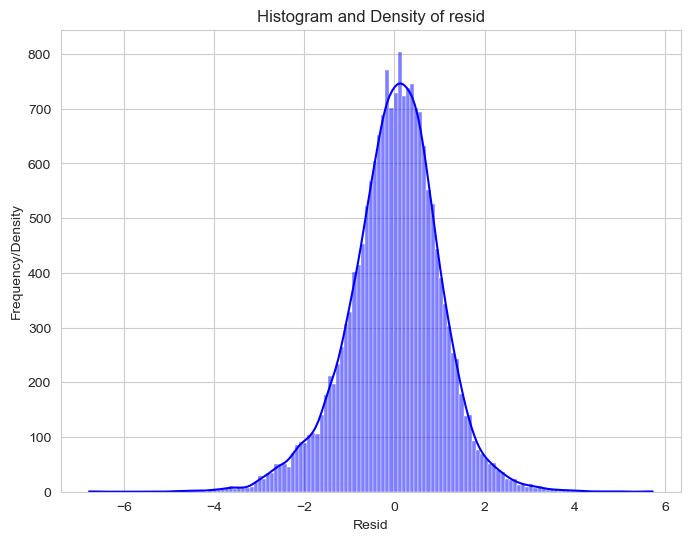

In [95]:
fig_hist_dens = Hist_Dens_resid(residuals)
plt.show()

----

### Parcial conclusion

In conclusion, the characteristics observed in the histogram of residuals, with a center around 0.3, a tail reaching 5.9, and another reaching 6.5, suggest that the model does not predict the data.

----

<a name="item3.1.4.2"></a>
##### 3.1.4.2. Residuals graph 

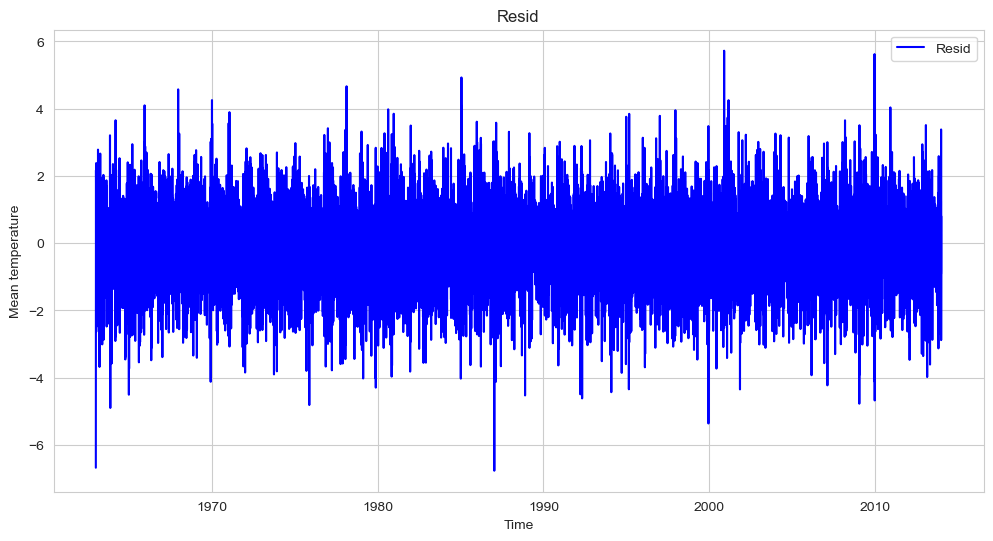

In [105]:
# Residual errors line graph

fig = Graphic_Serie(residuals, "Resid")


---
### Parcial conclusion

The residuals graph looks like white noise.

-----

<a name="item3.1.4.3"></a>
##### 3.1.4.3. Autocorrelation Function 

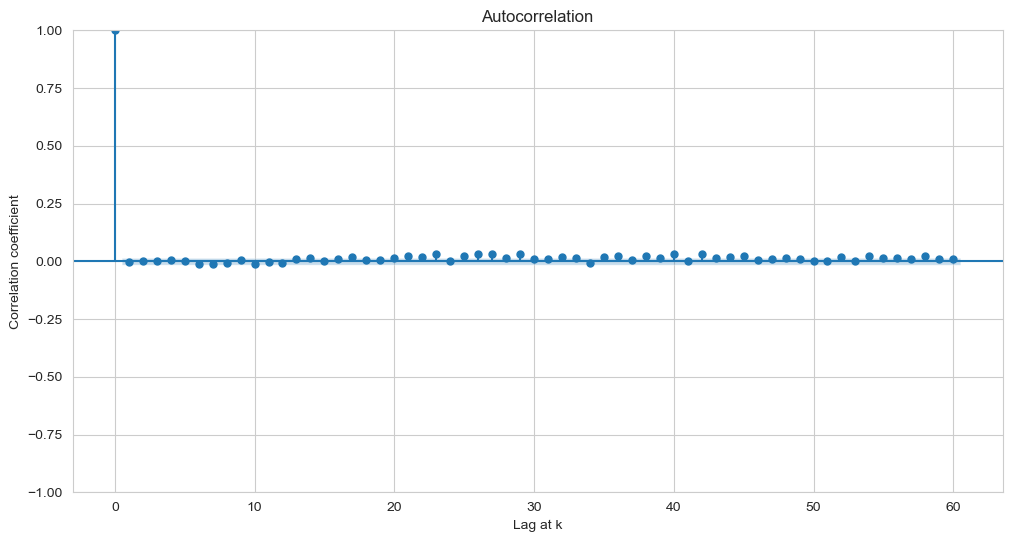

In [97]:
fig_ACF = Autocorrelation(residuals)


----
### Partial conclusion

When observing values slightly above the shaded area in the ACF of residuals, there might be patterns or structures in the residuals that haven't been fully captured by the model. 

----

<a name="item3.1.4.4"></a>
##### 3.1.4.4. Analyzing the decomposition of residuals

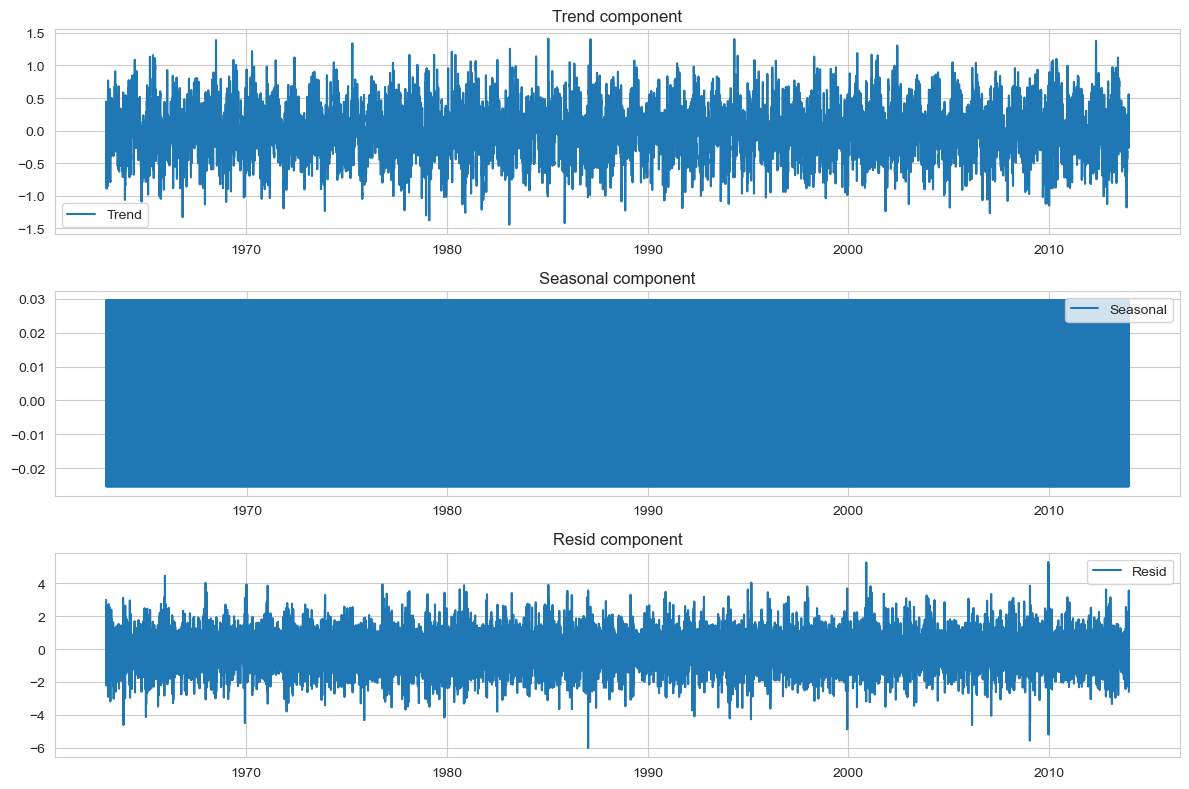

In [106]:
fig_desc = descomposition_serie(residuals)

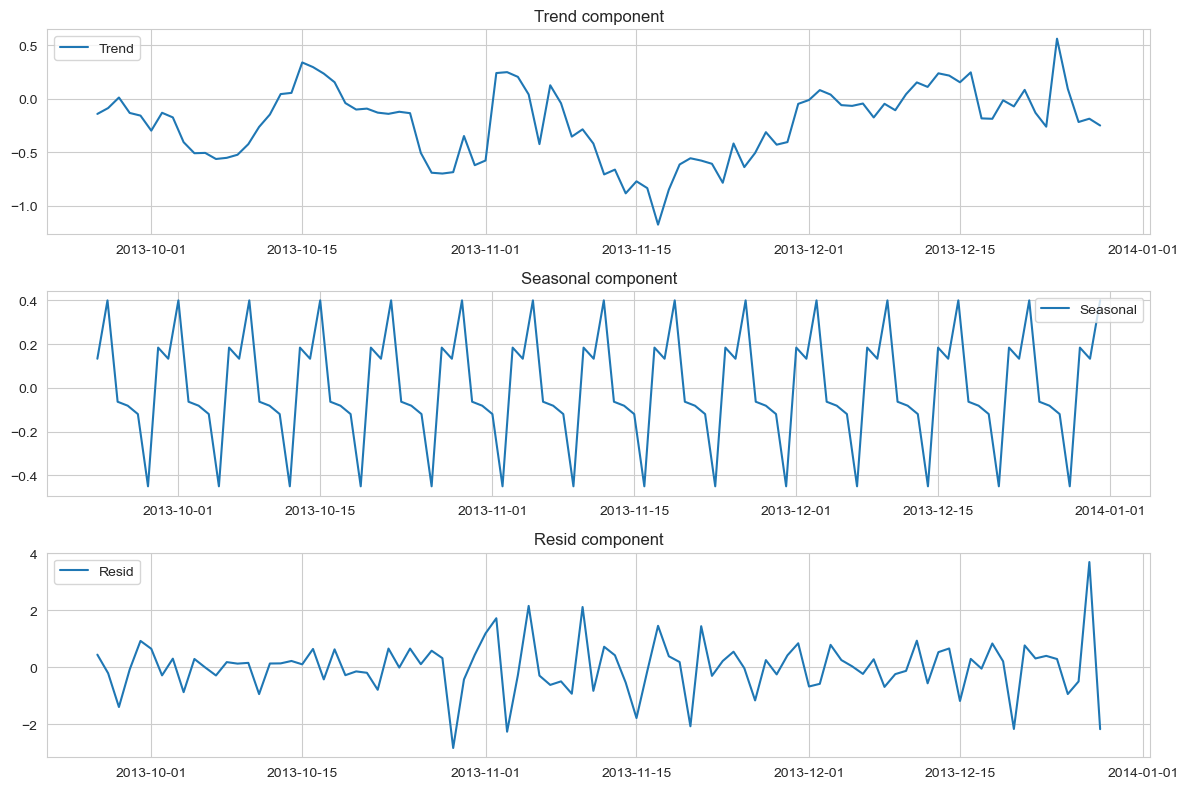

In [107]:
fig_desc = descomposition_serie(residuals[-100:])

----

### Parcial conclusion

When examining the decomposition of the residuals, patterns are observed in the series. This patterns indicate that the model did not succeed in making precise predictions.

----

<a name="item3.1.5"></a>
#### 3.1.5. Prediction

In [91]:
ARIMA_pred= model_arima_fit.get_prediction(start= len(X_train), end= len(X_train)+ len(X_test)-1)

In [92]:
print(ARIMA_pred)

In [35]:
import matplotlib.pyplot as plt

def Graphic_predict(X_train, X_test, model_predict):
    """
    Visualize predictions made by a time series model.

    Parameters:
    - X_train: DataFrame, training data with time series information.
    - X_test: DataFrame, testing data with time series information.
    - model_predict: Model prediction result object.

    Returns:
    - fig: Matplotlib Figure object.
    """
    try:
        # Get the predicted mean values
        predicted_mean = model_predict.predicted_mean

        # Get the confidence intervals (e.g., at 95%)
        confidence_interval = model_predict.conf_int(alpha=0.05)

        # Lower bound of the confidence interval
        lower_bound = confidence_interval.loc[:, 'lower Mean Temperature']

        # Upper bound of the confidence interval
        upper_bound = confidence_interval.loc[:, 'upper Mean Temperature']

    except:  # For Prophet model
        X_train = X_train.set_index('ds')
        X_test = X_test.set_index('ds')
        model_predict = model_predict.set_index('ds')

        # Get the predicted mean values
        predicted_mean = model_predict['yhat']

        # Lower bound of the confidence interval
        lower_bound = model_predict['yhat_lower']

        # Upper bound of the confidence interval
        upper_bound = model_predict['yhat_upper']

    # Create a figure with two subplots in one row and two columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting training, testing, and prediction data on the first subplot
    ax1.plot(X_train, color="black", linestyle='-', label='Training Data')
    ax1.plot(X_test, color="blue", linestyle='-', label='Testing Data')
    ax1.fill_between(X_test.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='Confidence Interval')
    ax1.plot(predicted_mean, color="red", linestyle='-', label='Model Predictions')
    ax1.set_title('Training, Testing, and Prediction Data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature Mean')
    ax1.legend()

    # Plotting testing and prediction data on the second subplot
    ax2.plot(X_test, color="blue", linestyle='-', label='Testing Data')
    ax2.fill_between(X_test.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='Confidence Interval')
    ax2.plot(predicted_mean, color="red", linestyle='-', label='Model Predictions')
    ax2.set_title('Testing and Prediction Data')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Temperature Mean')
    ax2.legend()

    return fig


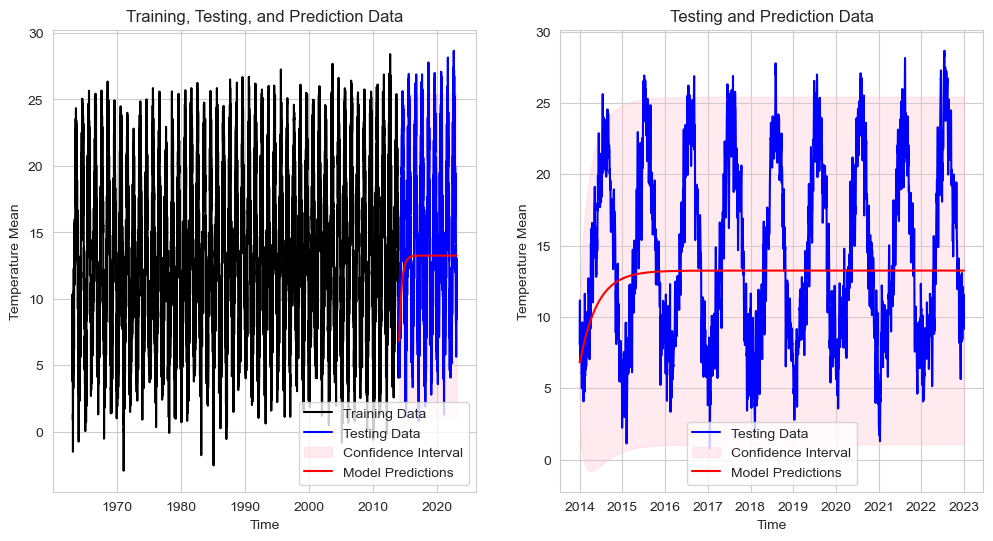

In [94]:
fig = Graphic_predict(X_train, X_test, ARIMA_pred)
plt.show()


----
### Partial conclusion

The results from the ARIMA model show a noticeable discrepancy from the actual data, indicating that the model's predictions do not align well with the real observations.

----

<a name="item3.1.6"></a>
#### 3.1.6. Model Metric

Although I already observe that the model doesn't align with the data, I will proceed to analyze the model metrics.

Model metrics help to evaluate the performance of a model and allows to qualitatively compare two models. 

The main metric that I am going to analyze is **coefficient of determination, or R-squared.**

R-squared, is a statistical measure that represents the proportion of the variance for a dependent variable that’s explained by an independent variable. That is, this is a measure that provides information about the goodness of fit of a model. It can range from 0 to 1.

In the context of a prediction model, "variance" generally refers to the variability or spread of values for a variable. Higher variance means that values are more spread out, while lower variance indicates that values tend to be closer to the mean.

- Dependent Variable (or Response): This is the variable you are trying to predict. In this case, it would be the future temperature.

- Independent Variable (or Predictor): This is the variable you are using to make the prediction. In this case, it is the past values of temperature that are used to predict the future temperature.

A perfect R-squared of 1.00 means that our predictor variables (in this case, it is Mean Temperature) explain 100% of the variance in the outcome we are trying to predict. In other words, an R-squared of 1.00 means that we can use the predictor variables to know precisely what the outcome’s value will be with no room for error. 

In [36]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

def Metrics (y_test,yhat):
    # Root mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    # Relative Absolute Error
    RAE = np.sum(np.abs(np.subtract(y_test, yhat))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))
    # Relative Square Error
    RSE = np.sum(np.square(np.subtract(y_test, yhat))) / np.sum(np.square(np.subtract(y_test, np.mean(y_test))))
    # R**2
    R2 = r2_score(y_test, yhat)

    print(f"MAE: {mean_absolute_error(y_test, yhat)}")
    print(f"MSE: {mean_squared_error(y_test, yhat)}")
    print('RMSE: %.3f' % rmse)
    print(f"R**2: {R2}")
    print(f"RAE: {RAE}")
    print(f"RSE: {RSE}")

In [88]:
Metrics(X_test.values,ARIMA_pred.predicted_mean.values)

MAE: 5.515610620857375
MSE: 42.22305464069846
RMSE: 6.498
R**2: -0.050742373895085846
RAE: 0.9992234375590094
RSE: 1.0507423738950858


----
### Partial conclusion
A negative R-squared can occur when the model performs worse than a simple model that predicts the mean of the dependent variable for all cases. In other words, the model isn't capturing any structure or pattern in the data and, instead, is making predictions that are worse than simply using the mean.

In this way, it confirmed that the model is not appropriate for this data.

----


<a name="item3.2"></a>
## 3.2 Sarima

The SARIMA model is a variant of the ARIMA model that includes a seasonal component. Unlike ARIMA, which adjusts the trend to make a non-stationary time series stationary, SARIMA can adjust the non-stationary time series by removing both trend and seasonality.

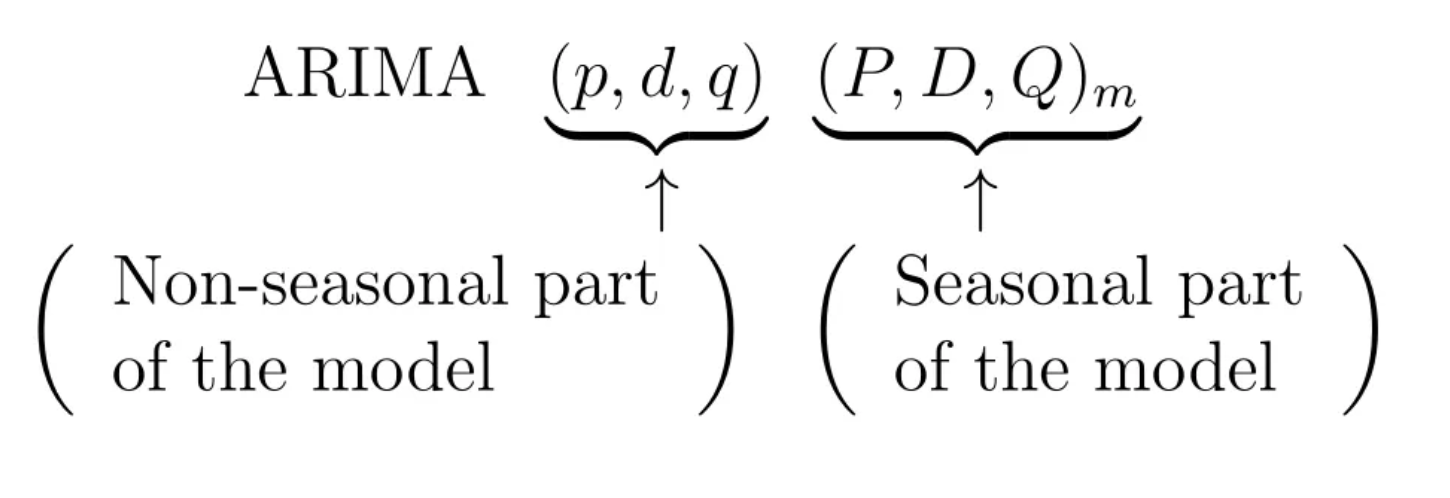

Non-seasonal part of the model:

- **p**: the order of the autoregressive trend
- **d**: the order of the trend differencing
- **q**: the order of the moving average trend

Seasonal part of the model:

- **P**: the order of the autoregressive seasonality. This component captures the relationship between the current value of the series and its past values, specifically in seasonal lags.
- **D**: the order of the seasonal differncing. This component represents the number of differentiations necessary to eliminate seasonality from the series.
- **Q**: the order of the moving average seasonality. This component shows the dependence between the current value and the residual errors of previous predictions at seasonal lags.
- **m**: the number of periods in your season

<a name="item3.2.1"></a>
### 3.2.1. Frequency of the time series

It is necessary to analyze the frequency of the data series. High frequencies lead to a high RAM requirement in SARIMA.
If you have daily data, converting it to monthly or quarterly is recommended.

In [72]:
def data_monthly(df):
    """
    This function converts the frequency of the data from daily to monthly.
    """

    # Extract the year from the index and create a new 'Year' column
    df["Year"] = df.index.year

    # Group by year and month, and aggregate the specified columns
    df = df.groupby([df["Year"], df.index.month]).agg({
        'Mean Temperature': 'mean',
        'Minimum Temperature': 'mean',
        'Maximum Temperature': 'mean',
        'Maximum Wind Speed': 'mean',
        'Total Precipitation': 'sum'
    }).reset_index()

    # Rename the 'Time' column to 'Month'
    df = df.rename(columns={'Time': 'Month'})

    # Combine 'Year' and 'Month' columns to create a new 'Time' column
    df['Time'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

    # Convert the 'Time' column to a period representing the month
    #df['Time'] = df['Time'].dt.to_period('M')

    df.index.freq = "M"

    # Set the 'Time' column as the index and drop the 'Month' and 'Year' columns
    df.set_index('Time', inplace=True)

    df = df.drop(['Month', 'Year'], axis=1)

    return df


In [73]:
monthly_spain = data_monthly(data_spain)

In [75]:
monthly_spain

,Mean Temperature,Minimum Temperature,Maximum Temperature,Maximum Wind Speed,Total Precipitation
Time,,,,,
1963-01-01,5.083871,2.267419,8.610000,16.433548,5236.3
1963-02-01,4.147143,0.893214,7.755000,19.621071,5176.8
1963-03-01,8.724839,4.660968,13.251290,20.040323,3246.3
1963-04-01,10.742000,6.111667,15.573333,17.437667,3672.7
1963-05-01,13.911613,8.767742,18.952581,15.423548,2249.6
...,...,...,...,...,...
2022-08-01,24.449355,18.742903,30.386774,16.209032,1406.1
2022-09-01,19.761333,15.115333,24.840000,16.073667,2477.6
2022-10-01,17.765806,13.383226,22.851613,15.408710,3159.5


<a name="item3.2.2"></a>
### 3.2.2. Chronological Arrangement of Time

In [40]:
data_spain = data_spain.sort_values(by ='Time')

In [60]:
monthly_spain.head()

,Mean Temperature,Minimum Temperature,Maximum Temperature,Maximum Wind Speed,Total Precipitation
Time,,,,,
1963-01,5.083871,2.267419,8.610000,16.433548,5236.3
1963-02,4.147143,0.893214,7.755000,19.621071,5176.8
1963-03,8.724839,4.660968,13.251290,20.040323,3246.3
1963-04,10.742000,6.111667,15.573333,17.437667,3672.7
1963-05,13.911613,8.767742,18.952581,15.423548,2249.6


Now, the data has a monthly frequency. Therefore, the SARIMA's parameter:

    m=12

<a name="item3.2.3"></a>
### 3.2.3. Train-Test Data Split

In [103]:
X_train, X_test = Train_Test_data(monthly_spain['Mean Temperature'], test_percentage = 0.10)

Training data: 648
Time
2016-08-01    23.568710
2016-09-01    20.594000
2016-10-01    15.953548
2016-11-01     9.744667
2016-12-01     7.818710
Name: Mean Temperature, dtype: float64



Test data: 72
Time
2017-01-01     5.375484
2017-02-01     8.455000
2017-03-01    10.486452
2017-04-01    13.452000
2017-05-01    17.325484
Name: Mean Temperature, dtype: float64


<a name="item3.2.4"></a>
### 3.2.4. Select Model Parameters with Auto_ARIMA

The auto_arima function is called to determine the best parameters for the data set for the Sarima model.

In [43]:
d_values = [0,1,2]
D_values = [0,1,2] 
startp= 0 
startq= 0 
maxp= 3 
maxq= 3 
startP= 0
startQ= 0
maxP= 3 
maxQ= 3 
m_value= 12 
seasonal_value= True 
stationary_value= False

SARIMA_op = S_ARIMA_options (X_train, d_values, D_values, startp, startq, maxp, maxq, startP, startQ, maxP, maxQ, m_value, seasonal_value, stationary_value)

print(SARIMA_op)
print()
print("The best model is:")
print()
print(SARIMA_op.sort_values(by= 'AIC', ascending=True).head(1))

 Alternative models with d: 0 and D: 0

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4127.462, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3178.153, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5306.547, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3522.360, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2159.474, Time=1.76 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2496.955, Time=1.08 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2168.189, Time=4.62 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3007.108, Time=1.23 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=2315.792, Time=3.07 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2196.744, Time=0.87 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=2178.406, Time=1.1

 ARIMA(3,1,0)(3,1,0)[12] intercept   : AIC=2278.084, Time=2.75 sec

Best model:  ARIMA(3,1,0)(3,1,0)[12]          
Total fit time: 65.261 seconds

***************************

 Alternative models with d: 1 and D: 2

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3386.568, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=2898.739, Time=0.29 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=3.42 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3267.691, Time=0.14 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=2714.409, Time=0.58 sec
 ARIMA(1,1,0)(3,2,0)[12]             : AIC=2618.616, Time=1.32 sec
 ARIMA(1,1,0)(3,2,1)[12]             : AIC=inf, Time=8.92 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=7.05 sec
 ARIMA(0,1,0)(3,2,0)[12]             : AIC=2723.859, Time=0.75 sec
 ARIMA(2,1,0)(3,2,0)[12]             : AIC=2583.422, Time=2.46 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=2673.900, Time=1.09 sec
 ARIMA(2,1,0)(3,2,1

<a name="item3.2.5"></a>
### 3.2.5. SARIMA Model Creation

The dataset used in the ARIMA or ARIMA model is the original, without differentiation. The values of d and D determine the differentiation necessary to be stationary.

In [104]:
# Create SARIMA Model 
model_sarima = sm.tsa.statespace.SARIMAX(X_train, order=(1, 0, 0),seasonal_order=(0, 1, 1, 12))

model_sarima_fit = model_sarima.fit()

print(model_sarima_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67170D+00    |proj g|=  2.59544D-01

At iterate    5    f=  1.59414D+00    |proj g|=  4.73950D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   5.292D-06   1.594D+00
  F =   1.5938992861966446     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                       
Dep. Variable:                     Mean Temperature   No. Observations:                  648
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1032.847
Date:                              Sun, 14 Jan 2024   AIC                           2071.693
Time:                                      20:27:58

<a name="item3.2.6"></a>
### 3.2.6. Analysis of the prediction residual

In [101]:
# 'residuals' is an attribute that contains the residuals of the ARIMA model.
residuals_S = model_sarima_fit.resid 
residuals_S.head(5)

Time
1963-01-01     5.083871
1963-02-01     4.147140
1963-03-01     8.724835
1963-04-01    10.741993
1963-05-01    13.911604
dtype: float64

<a name="item3.2.6.1"></a>
#### 3.2.6.1. Histogram and Density

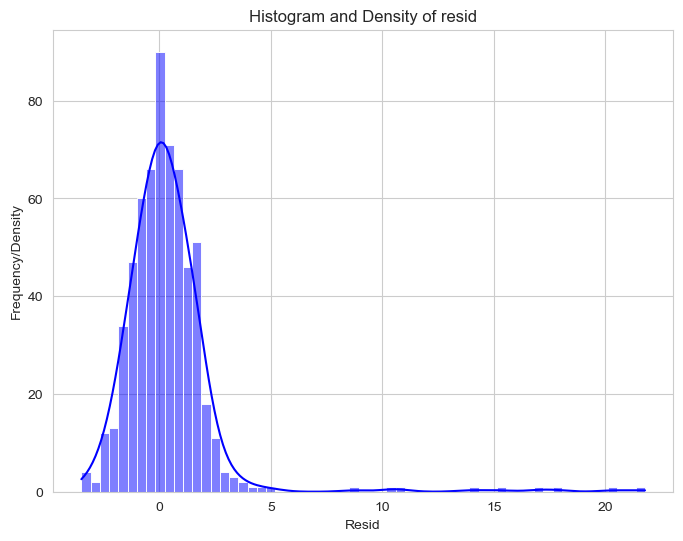

In [105]:
fig_hist_dens_S = Hist_Dens_resid(residuals_S)

----
### Parcial conclusion
The histogram of residuals has a center around 0, a tail reaching -3, and another reaching 20. This can indicate overfiting.

---

<a name="item3.2.6.2"></a>
#### 3.2.6.2. Residuals graph

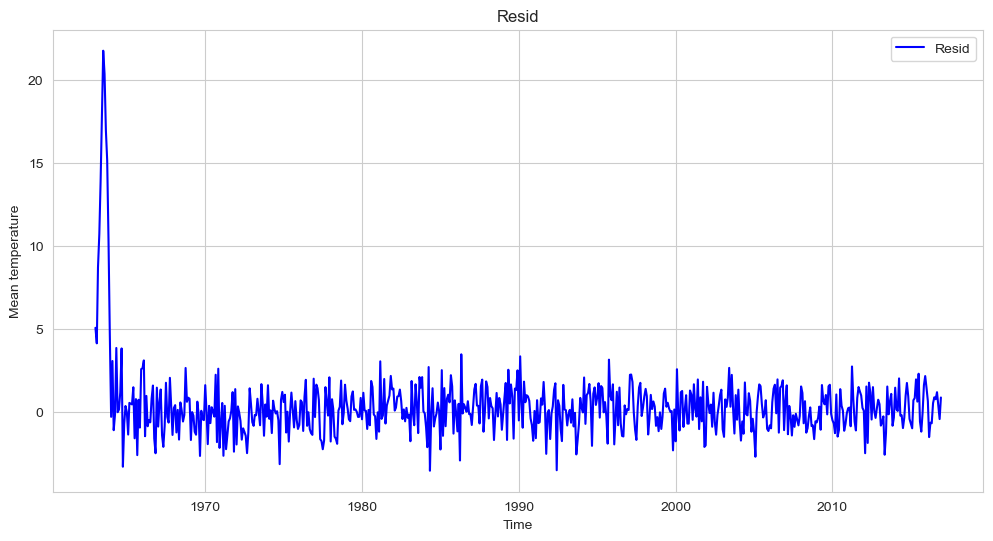

In [87]:
fig_S = Graphic_Serie(residuals_S, "Resid")

<a name="item3.2.6.3"></a>
#### 3.2.6.3. Autocorrelation Function

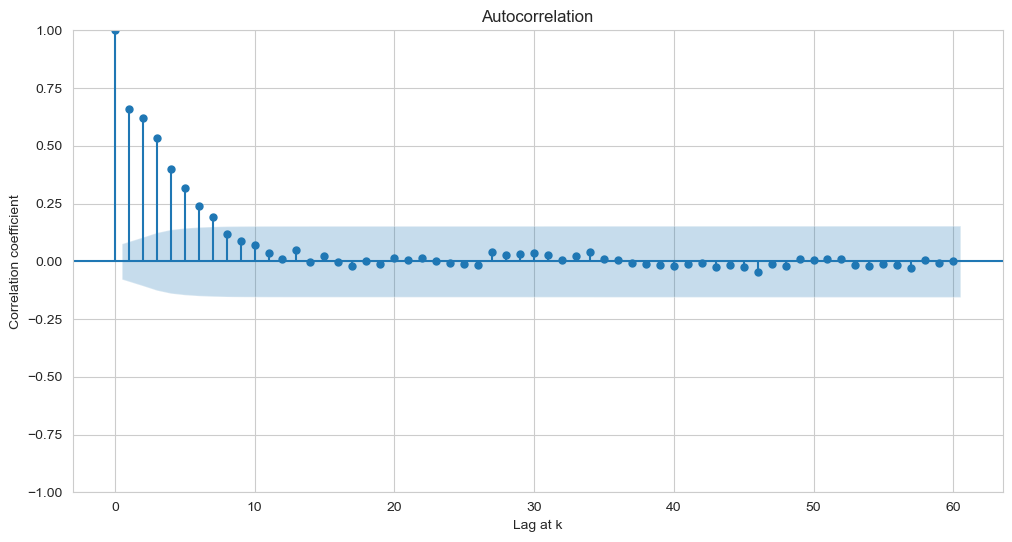

In [88]:
fig_ACF_S = Autocorrelation(residuals_S)

----
### Parcial conclusion

The autocorrelation function (ACF) plot of the model's residuals exhibits significant values, it indicates the presence of serial correlation. This suggests that the residuals at a given time point are related to residuals at previous or subsequent time points. The significant peaks in the ACF plot imply that there are patterns or structures in the residuals not adequately captured by the model. 

---

<a name="item3.2.6.4"></a>
#### 3.2.6.4. Analyzing the decomposition of residuals

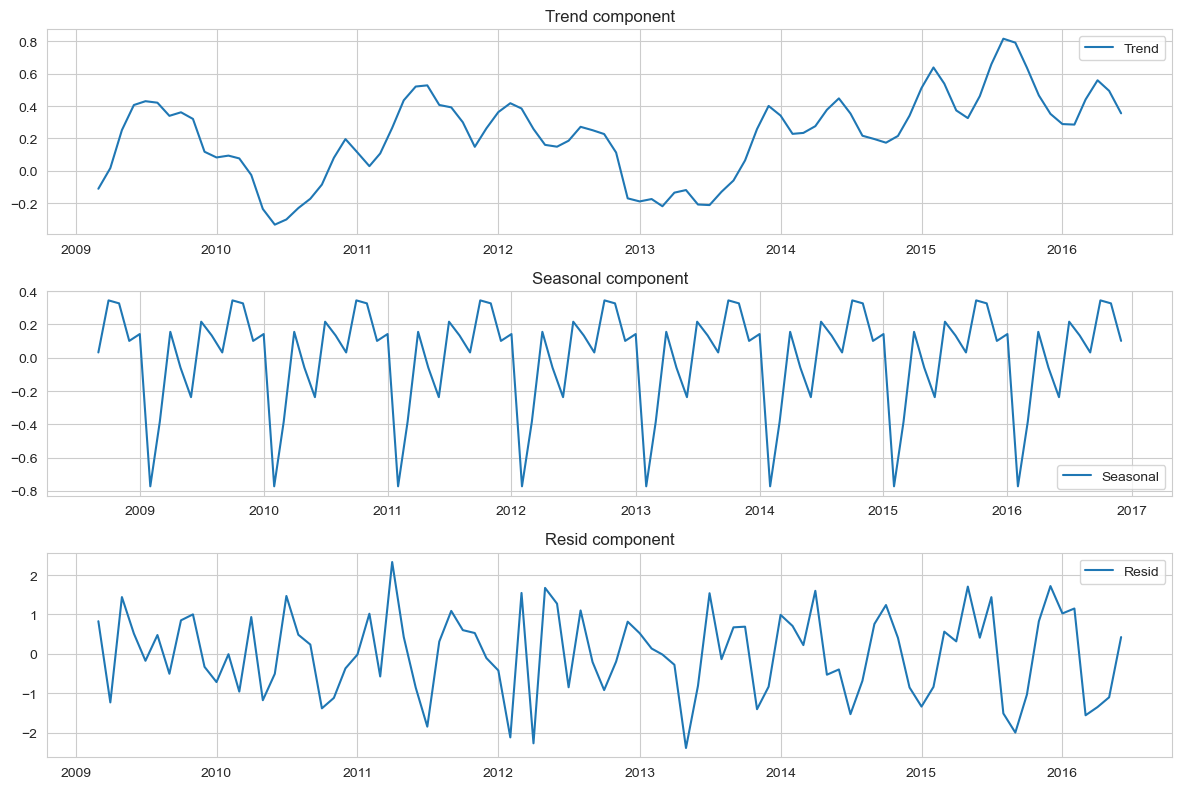

In [97]:
fig_desc_S = descomposition_serie(residuals_S[-100:])

----
### Parcial conclusion

Decomposing the residuals of the model reveals the presence of both trend and seasonality. This indicates that the model hasn't captured all the underlying patterns within the dataset.

---

<a name="item3.2.7"></a>
### 3.2.7. Prediction

In [92]:
SARIMA_pred = model_sarima_fit.get_prediction(start=len(X_train), end=len(X_train) + len(X_test) - 1)

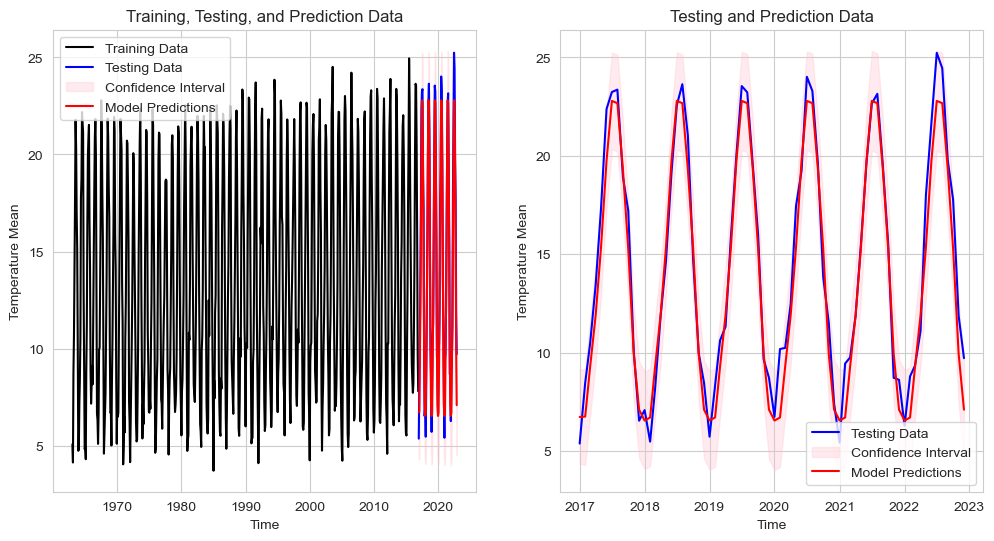

In [93]:
fig_S = Graphic_predict(X_train, X_test, SARIMA_pred)
plt.show()

---
### Parcial conclusion
The constant and increasing discrepancy between predictions and observations may be due to the model's inability to fit both trend and seasonality in the data adequately. If the predicted graph is consistently below the actual graph, it suggests that the model did not correctly fit the trend. At the same time, the increase in the difference over time indicates problems capturing seasonality.

---

<a name="item3.2.8"></a>
### 3.2.8. Model Metrics

In [94]:
Metrics(X_test.values,SARIMA_pred.predicted_mean.values)

MAE: 1.0313518120719485
MSE: 1.7234381151939238
RMSE: 1.313
R**2: 0.9524951040737525
RAE: 0.19093380249573924
RSE: 0.04750489592624754


---
### Parcial conclusion

To summarize, while the R^2 value is high, the asymmetry in residual density and the growing difference between predicted and observed values indicate that there is a possibility of improving the model. This can be achieved by either modifying the model specifications, exploring transformations in the data or trying out different modeling techniques.

----